## https://courseworks2.columbia.edu/courses/190553/files/19587975?wrap=1
## Trading strategy of a stock index based on the frequency of news releases for listed companies

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np

import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(6666)

from tqdm import tqdm
import concurrent.futures

In [2]:
def load_financial_data(ticker:str, start_date, end_date,output_file):
    try:
        df = pd.read_pickle(output_file)
        print(f'File data found...reading {ticker} data')
    except FileNotFoundError:
        print(f'File not found...downloading the {ticker} data')
        df = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
        df.to_pickle(output_file)
    return df

In [3]:
spy_data=load_financial_data('SPY', start_date=datetime(2000,1,1), end_date = datetime(2024,1,1), output_file='spy_data.pkl')
spy_data.to_csv('spy.csv')
spy_data = spy_data.iloc[2300:4730]
spy_data.head()

File data found...reading SPY data


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-02-26,77.820000,79.669998,75.529999,75.620003,56.646458,363353900
2009-02-27,74.010002,75.690002,73.809998,73.930000,55.380478,470510900
2009-03-02,72.519997,73.919998,70.370003,70.599998,52.885998,426452600
2009-03-03,71.610001,71.699997,69.639999,70.070000,52.488968,443761000
2009-03-04,71.230003,72.870003,70.070000,71.730003,53.732487,462753100


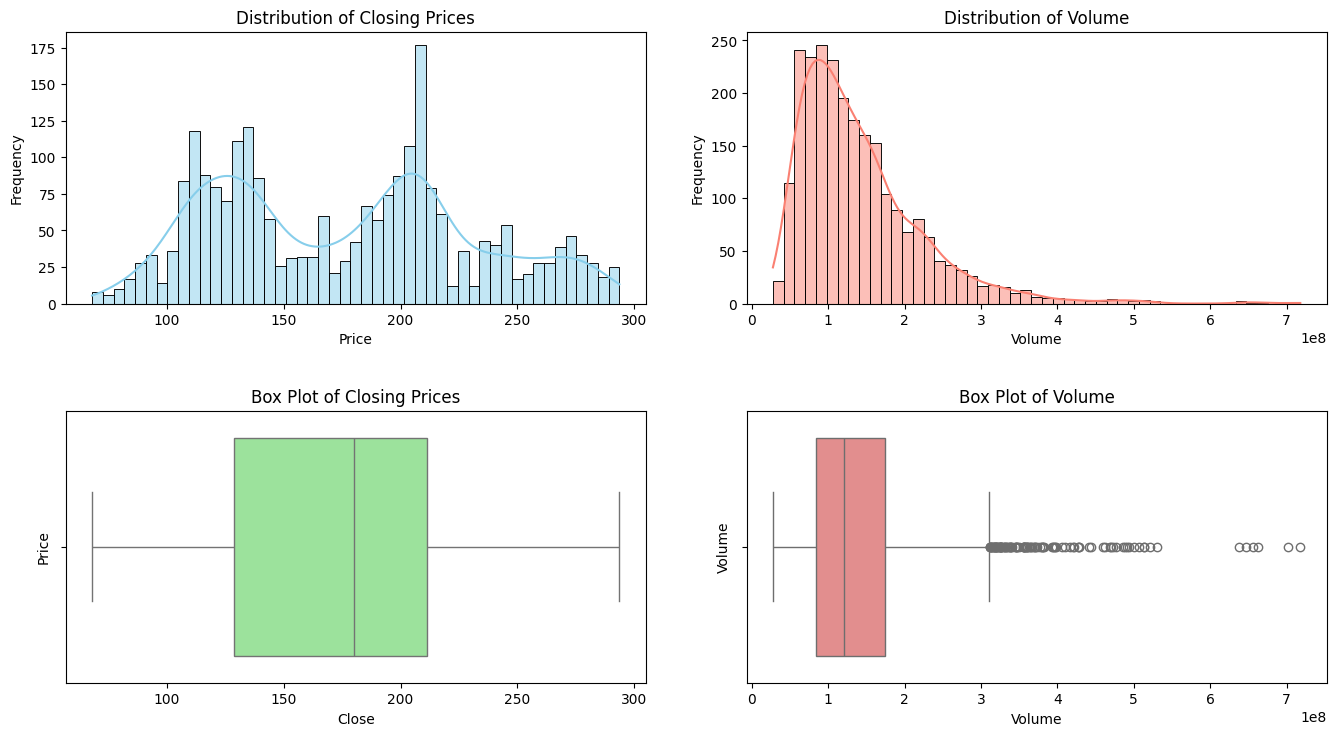

Summary Statistics:
              Open         High          Low        Close    Adj Close  \
count  2430.000000  2430.000000  2430.000000  2430.000000  2430.000000   
mean    176.200111   177.044111   175.287053   176.236955   148.890626   
std      54.791794    54.840989    54.701263    54.770170    54.125492   
min      67.949997    70.000000    67.099998    68.110001    51.020748   
25%     128.737495   129.330002   127.925003   128.672497   101.493004   
50%     180.255005   180.980003   179.270004   180.290001   149.489929   
75%     211.202496   211.927502   210.442501   211.155003   181.733498   
max     293.089996   293.940002   291.809998   293.579987   266.941162   

             Volume  Daily_Returns  
count  2.430000e+03    2429.000000  
mean   1.415118e+08       0.000583  
std    8.187412e+07       0.009945  
min    2.785650e+07      -0.065123  
25%    8.381562e+07      -0.003472  
50%    1.212992e+08       0.000603  
75%    1.745683e+08       0.005325  
max    7.178287e+

In [4]:
# Calculate Daily Returns
spy_data['Daily_Returns'] = spy_data['Close'].pct_change()

# Summary statistics
summary_stats = spy_data.describe()

# Calculate the number of bins based on the square root of the number of entries
num_bins = int(np.sqrt(len(spy_data.index)))

# Visualizations
plt.figure(figsize=(14, 8))  # Adjust the figure size

# Distribution of prices
plt.subplot(2, 2, 1)
sns.histplot(spy_data['Close'], bins=num_bins, color='skyblue', edgecolor='black', kde=True)
plt.title('Distribution of Closing Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Volume distribution
plt.subplot(2, 2, 2)
sns.histplot(spy_data['Volume'], bins=num_bins, color='salmon', edgecolor='black', kde=True)
plt.title('Distribution of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')

# Box plot of prices
plt.subplot(2, 2, 3)
sns.boxplot(x=spy_data['Close'], color='lightgreen')
plt.title('Box Plot of Closing Prices')
plt.ylabel('Price')

# Box plot of volume
plt.subplot(2, 2, 4)
sns.boxplot(x=spy_data['Volume'], color='lightcoral')
plt.title('Box Plot of Volume')
plt.ylabel('Volume')

plt.tight_layout(pad=3)  # Add padding between subplots
plt.show()

# Summary statistics
print("Summary Statistics:")
print(summary_stats)


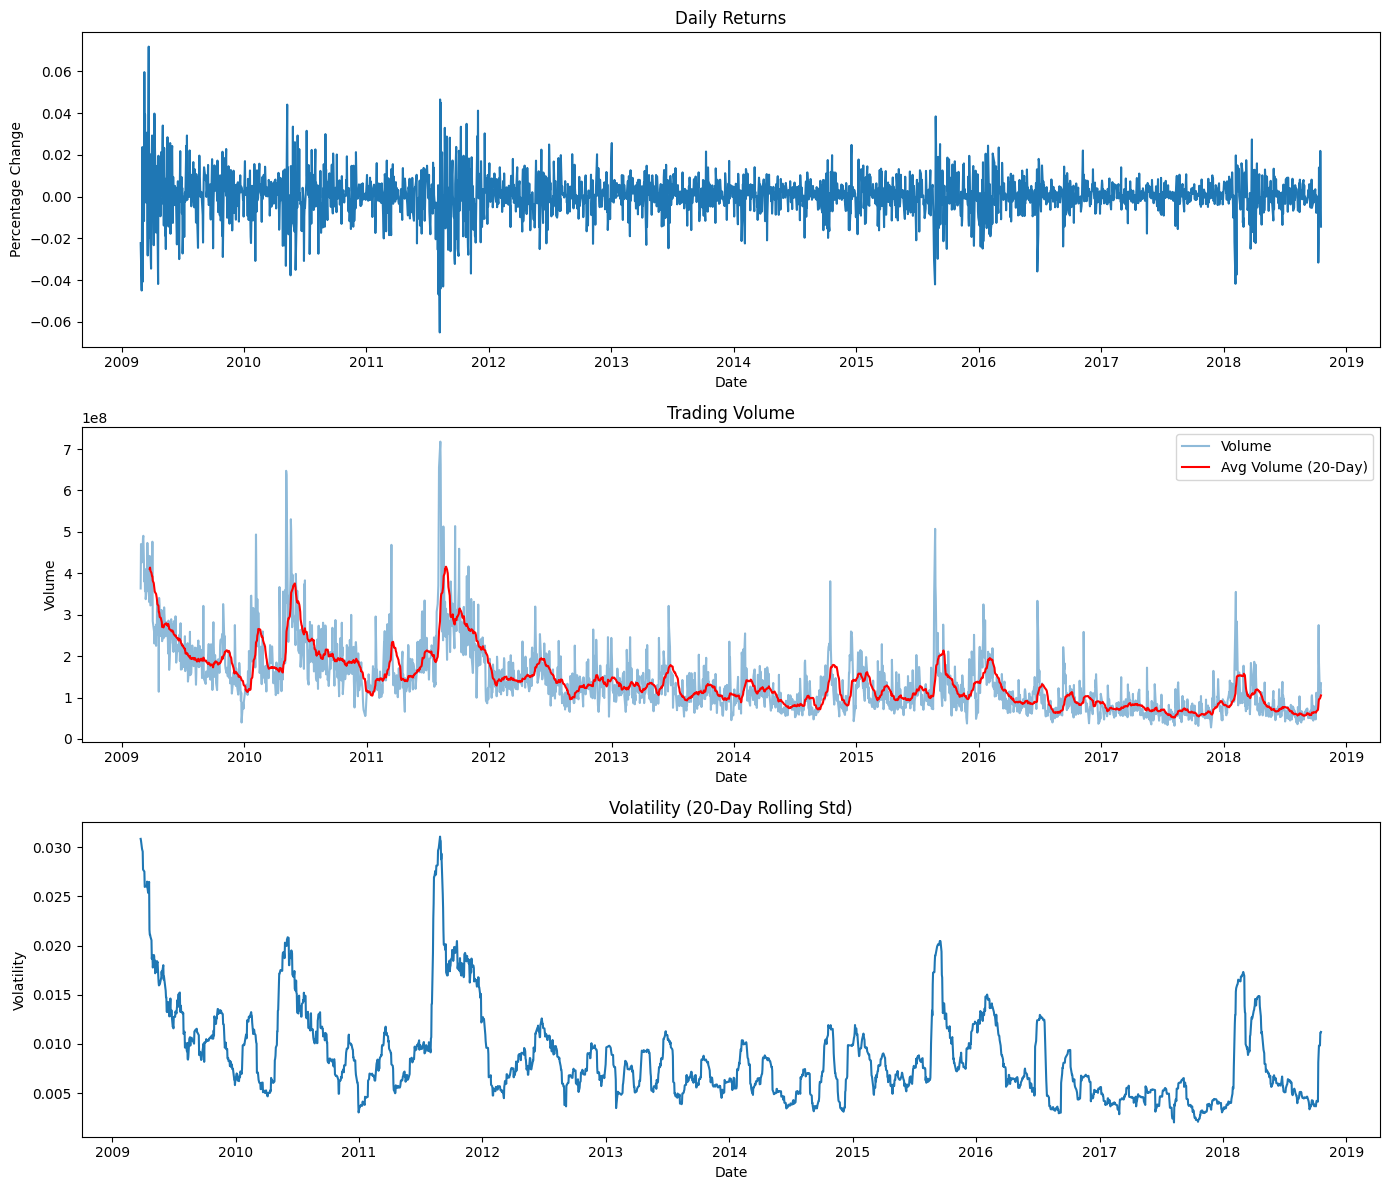

In [5]:
# Calculate Daily Returns
spy_data['Daily_Returns'] = spy_data['Close'].pct_change()

# Calculate Average Daily Trading Volume (rolling mean)
spy_data['Avg_Volume'] = spy_data['Volume'].rolling(window=20).mean()

# Calculate Volatility (e.g., 20-day rolling standard deviation of returns)
spy_data['Volatility'] = spy_data['Daily_Returns'].rolling(window=20).std()

# Plotting
plt.figure(figsize=(14, 12))

# Daily Returns
plt.subplot(3, 1, 1)
plt.plot(spy_data.index, spy_data['Daily_Returns'])
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Percentage Change')

# Average Daily Trading Volume
plt.subplot(3, 1, 2)
plt.plot(spy_data.index, spy_data['Volume'], label='Volume', alpha=0.5)
plt.plot(spy_data.index, spy_data['Avg_Volume'], label='Avg Volume (20-Day)', color='red')
plt.title('Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()

# Volatility
plt.subplot(3, 1, 3)
plt.plot(spy_data.index, spy_data['Volatility'])
plt.title('Volatility (20-Day Rolling Std)')
plt.xlabel('Date')
plt.ylabel('Volatility')

plt.tight_layout()
plt.show()


## News Data

In [6]:
import feedparser
from urllib.parse import quote

In [7]:
def encode_string_to_url(input_string):
    encoded_string = quote(input_string)
    return encoded_string

def construct_rss_url(after='2020-06-01', before='2020-06-02', search_terms = ['S&P500', 'SPY TICKER', 'S&P']):
    search_term = '%20OR%20'.join([encode_string_to_url(st) for st in search_terms])
    endpoint = f'https://news.google.com/rss/search?q={search_term}+after:{after}+before:{before}&ceid=US:en&hl=en-US&gl=US'
    return endpoint

def parse_rss_feed(url):
    # Parse the RSS feed
    feed = feedparser.parse(url)

    # Check if the feed parsing was successful
    if feed.bozo == 0:
        return len(feed.entries)
    else:
        # print("Error parsing the RSS feed.")
        raise Exception('Failed feed pull')

In [8]:
news_articles_df = pd.DataFrame(index=spy_data.index, columns=['article_count']).iloc[2300:4730]

In [9]:
def load_news_data(output_file):
    try:
        df = pd.read_pickle(output_file)
        print(f'File data found...reading news data')
    except FileNotFoundError:
        # Function to process each date
        def process_date(date):
            after = date.strftime('%Y-%m-%d')
            before = (date + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
            return parse_rss_feed(construct_rss_url(after, before))
        
        # Create ThreadPoolExecutor with maximum workers equal to the number of available CPUs
        with concurrent.futures.ThreadPoolExecutor() as executor:
            # Process each date in parallel
            results = list(tqdm(executor.map(process_date, spy_data.index), total=len(spy_data.index)))
        
        # Combine results into a DataFrame
        for i, date in enumerate(spy_data.index):
            news_articles_df.at[date, 'article_count'] = results[i]
        
        # Save the DataFrame to pickle file
        news_articles_df.to_pickle(output_file)
        
        df = news_articles_df  # Assigning df to the DataFrame after loading the news data
        
    return df

# Load news data in parallel
news_articles_df = load_news_data('news_articles.pkl')

# Save the DataFrame to CSV
news_articles_df.to_csv('news_articles.csv')


File data found...reading news data


In [10]:
((news_articles_df['article_count'].shift() - news_articles_df['article_count'] < 0) * 1.0).sum()

1447.0

## Data Exploration

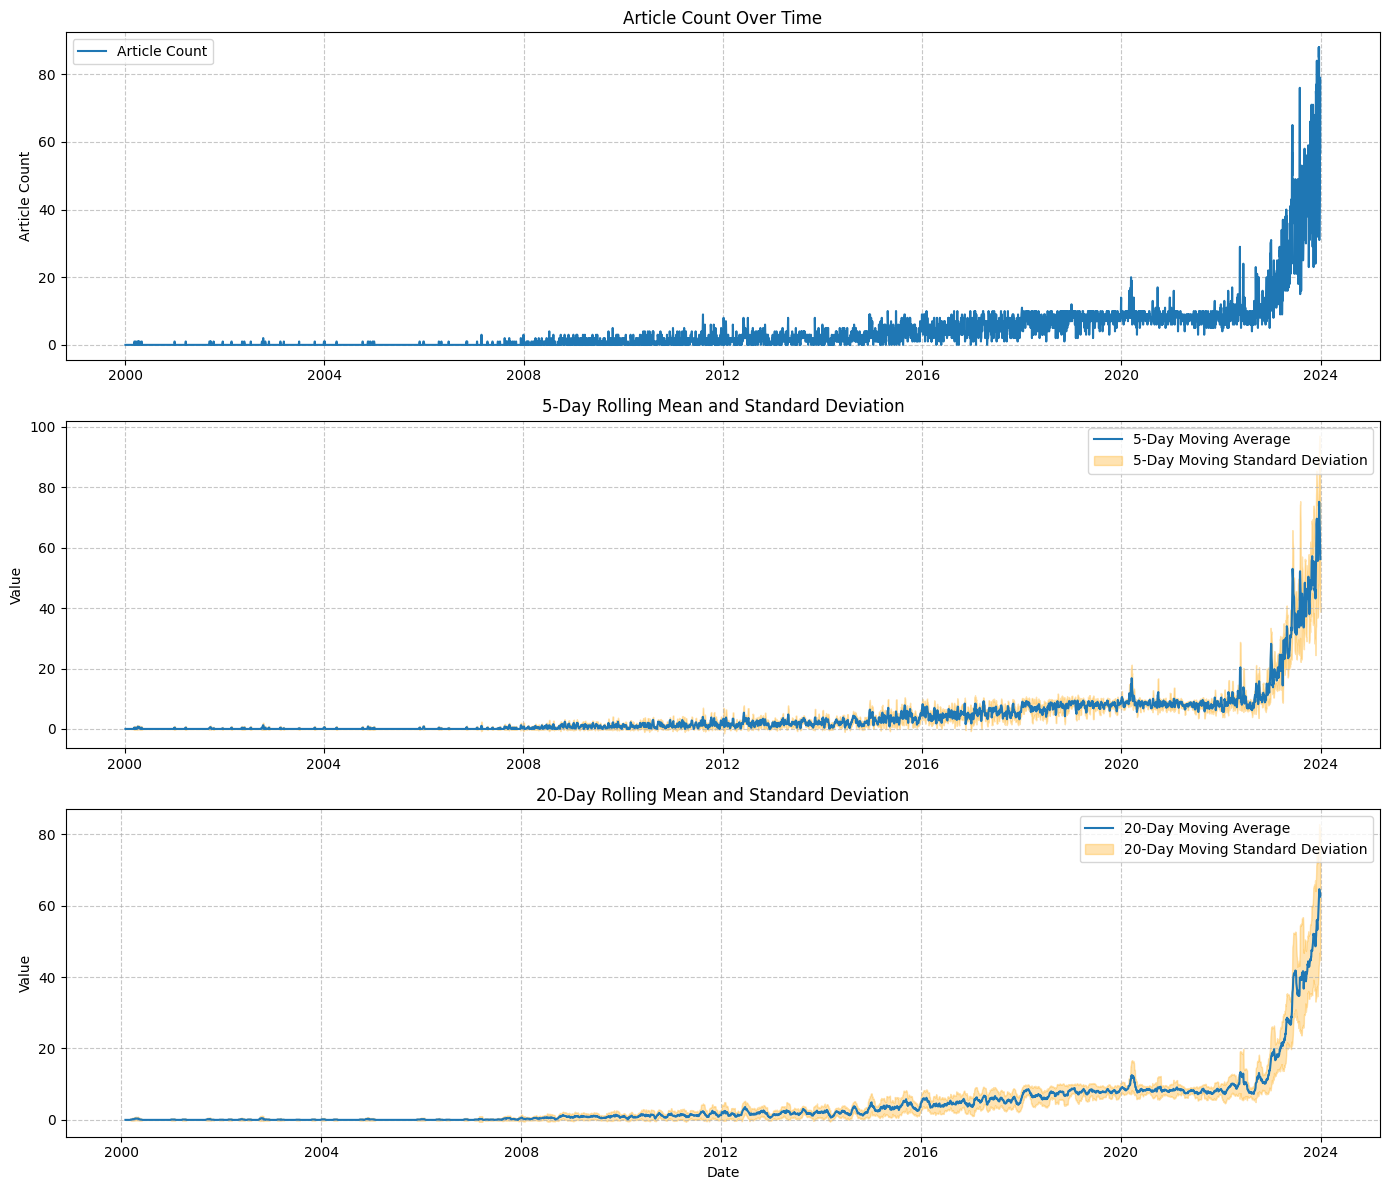

In [11]:
plot_window_1 = 5
plot_window_2 = 20

# Create subplots with three vertically stacked axes
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))

# Plot article count on the first subplot
ax1.plot(news_articles_df.index, news_articles_df['article_count'], label='Article Count')
ax1.set_title('Article Count Over Time')
ax1.set_ylabel('Article Count')

# Plot moving average and standard deviation for 5-day window on the second subplot
ax2.plot(news_articles_df.index, news_articles_df['article_count'].rolling(window=plot_window_1).mean(), label=f'{plot_window_1}-Day Moving Average')
ax2.fill_between(news_articles_df.index, 
                 news_articles_df['article_count'].rolling(window=plot_window_1).mean() - news_articles_df['article_count'].rolling(window=plot_window_1).std(), 
                 news_articles_df['article_count'].rolling(window=plot_window_1).mean() + news_articles_df['article_count'].rolling(window=plot_window_1).std(), 
                 color='orange', alpha=0.3, label=f'{plot_window_1}-Day Moving Standard Deviation')
ax2.set_title(f'{plot_window_1}-Day Rolling Mean and Standard Deviation')
ax2.set_ylabel('Value')

# Plot moving average and standard deviation for 20-day window on the third subplot
ax3.plot(news_articles_df.index, news_articles_df['article_count'].rolling(window=plot_window_2).mean(), label=f'{plot_window_2}-Day Moving Average')
ax3.fill_between(news_articles_df.index, 
                 news_articles_df['article_count'].rolling(window=plot_window_2).mean() - news_articles_df['article_count'].rolling(window=plot_window_2).std(), 
                 news_articles_df['article_count'].rolling(window=plot_window_2).mean() + news_articles_df['article_count'].rolling(window=plot_window_2).std(), 
                 color='orange', alpha=0.3, label=f'{plot_window_2}-Day Moving Standard Deviation')
ax3.set_title(f'{plot_window_2}-Day Rolling Mean and Standard Deviation')
ax3.set_xlabel('Date')
ax3.set_ylabel('Value')

# Add gridlines and legend to all subplots
for ax in (ax1, ax2, ax3):
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()

# Adjust layout and display plot
plt.tight_layout()
plt.show()


## Backtest

In [12]:
def backtest(orders, initial_capital = 100, risk_free_rate = 0.0467):
    portfolio = pd.DataFrame(index=spy_data.index)
    portfolio['orders'] = orders

    portfolio['cash'] = 0
    portfolio['holding'] = 0
    portfolio['total'] = 0
    portfolio['max_drawdown'] = 0  # New column for maximum drawdown
    portfolio['sharpe_ratio'] = 0  # New column for Sharpe Ratio
    portfolio.at[portfolio.index[0], 'cash'] = initial_capital

    max_value = initial_capital
    returns = []

    for i in range(1, len(portfolio)):
        if portfolio.at[portfolio.index[i], 'orders'] == 1:
            portfolio.at[portfolio.index[i], 'holding'] = portfolio.at[portfolio.index[i-1], 'cash'] / spy_data['Close'][i]
            portfolio.at[portfolio.index[i], 'cash'] = 0
        elif portfolio.at[portfolio.index[i], 'orders'] == -1:
            portfolio.at[portfolio.index[i], 'cash'] = portfolio.at[portfolio.index[i-1], 'holding'] * spy_data['Close'][i]
            portfolio.at[portfolio.index[i], 'holding'] = 0
        else:
            portfolio.at[portfolio.index[i], 'cash'] = portfolio.at[portfolio.index[i-1], 'cash']
            portfolio.at[portfolio.index[i], 'holding'] = portfolio.at[portfolio.index[i-1], 'holding']


    # Update total value and calculate drawdown
        portfolio.at[portfolio.index[i], 'total'] = portfolio.at[portfolio.index[i], 'cash'] + portfolio.at[portfolio.index[i], 'holding'] * spy_data['Close'][i]
        
        max_value = max(max_value, portfolio.at[portfolio.index[i], 'total'])
        portfolio.at[portfolio.index[i], 'max_drawdown'] = (max_value - portfolio.at[portfolio.index[i], 'total']) / max_value

    # Calculate daily returns
        if i > 1:
            daily_return = (portfolio.at[portfolio.index[i], 'total'] / portfolio.at[portfolio.index[i-1], 'total']) - 1
            returns.append(daily_return)
            #  Calculate Sharpe Ratio
            if pd.Series(returns).std() != 0:
                excess_returns = pd.Series(returns) - risk_free_rate
                sharpe_ratio = (excess_returns.mean() / excess_returns.std())
            else:
                sharpe_ratio = 0.0
            portfolio.at[portfolio.index[i], 'sharpe_ratio'] = sharpe_ratio


    return portfolio

In [13]:
def portfolio_signals(portfolios):
    num_portfolios = len(portfolios)
    fig, axs = plt.subplots(num_portfolios, 1, figsize=(14, 7*num_portfolios))

    for i, (portfolio, ax) in enumerate(zip(portfolios, axs)):
        ax.plot(spy_data.index, spy_data['Close'], label='SPX Close Price')
        ax.plot(portfolio[portfolio['orders'] == 1].index, spy_data['Close'][portfolio['orders'] == 1], '^', markersize=5, color='g', label='Buy Signal')
        ax.plot(portfolio[portfolio['orders'] == -1].index, spy_data['Close'][portfolio['orders'] == -1], 'v', markersize=5, color='r', label='Sell Signal')
        ax.set_title(f'Portfolio {i} Buy and Sell Signals')
        ax.legend()

    plt.tight_layout()
    plt.show()

In [14]:
def portfolio_val_over_time(portfolios):
    num_portfolios = len(portfolios)
    fig, axs = plt.subplots(num_portfolios, 1, figsize=(14, 7*num_portfolios))

    for i, (portfolio, ax) in enumerate(zip(portfolios, axs)):
        ax.plot(portfolio.index, portfolio['total'], label='Total Value')
        #ax.plot(portfolio.index, portfolio['cash'], label='Cash')
        #ax.plot(portfolio.index, portfolio['holding'], label='Holding Value')
        ax.set_title(f'Portfolio {i} Value Over Time')
        ax.legend()

    plt.tight_layout()
    plt.show()


In [15]:
def plot_portfolio(portfolios, column='max_drawdown'):
    fig, ax = plt.subplots(figsize=(14, 7))

    for i, portfolio in enumerate(portfolios):
        ax.plot(portfolio.index, portfolio[column], label=f'Portfolio {i} - {column}')

    ax.set_title('Portfolios')
    ax.legend()
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.show()


In [16]:
signals = pd.DataFrame(index=spy_data.index)

signals['signal'] = 1
signals.at[signals.index[0], 'signal'] = 0
signals['orders'] = signals['signal'].diff()
portfolio_0 = backtest(signals['orders'])
print(portfolio_0.at[portfolio_0.index[-1], 'total'])


signals['signal'] = [random.randint(0, 1) for _ in range(len(signals))]
signals['orders'] = signals['signal'].diff()
portfolio_1 = backtest(signals['orders'])
print(portfolio_1.at[portfolio_1.index[-1], 'total'])


signals['signal'] = (news_articles_df['article_count'].shift() - news_articles_df['article_count'] < 0) * 1.0
signals['orders'] = signals['signal'].diff()
portfolio_2 = backtest(signals['orders'])
print(portfolio_2.at[portfolio_2.index[-1], 'total'])


# Calculate the sum of articles for each week
news_articles_df['article_count_weekly'] = news_articles_df['article_count'].rolling(window=7).sum()

# Shift the weekly sum to represent the previous week
news_articles_df['article_count_weekly_shifted'] = news_articles_df['article_count_weekly'].shift()

# Set the signal to 1 when the sum of articles from the previous week is less than the sum of this week
signals['signal'] = (news_articles_df['article_count_weekly_shifted'] < news_articles_df['article_count_weekly']).astype(float)
signals['orders'] = signals['signal'].diff()
portfolio_3 = backtest(signals['orders'])
print(portfolio_3.at[portfolio_3.index[-1], 'total'])

# Calculate the 5-day and 20-day moving averages
spy_data['MA5'] = spy_data['Close'].rolling(window=5).mean()
spy_data['MA20'] = spy_data['Close'].rolling(window=20).mean()

# Create a new signal based on the moving averages
signals['signal'] = 0
signals['signal'][5:] = np.where(spy_data['MA5'][5:] > spy_data['MA20'][5:], 1, 0)
signals['orders'] = signals['signal'].diff()

# Perform backtesting with the new signal
portfolio_4 = backtest(signals['orders'])
print(portfolio_4.at[portfolio_4.index[-1], 'total'])


373.86716184976643
212.95848582297313
163.29876047086242
113.5404808084455


C:\Users\chaud\AppData\Local\Temp\ipykernel_1980\696592052.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['signal'][5:] = np.where(spy_data['MA5'][5:] > spy_data['MA20'][5:], 1, 0)


148.0966678794859


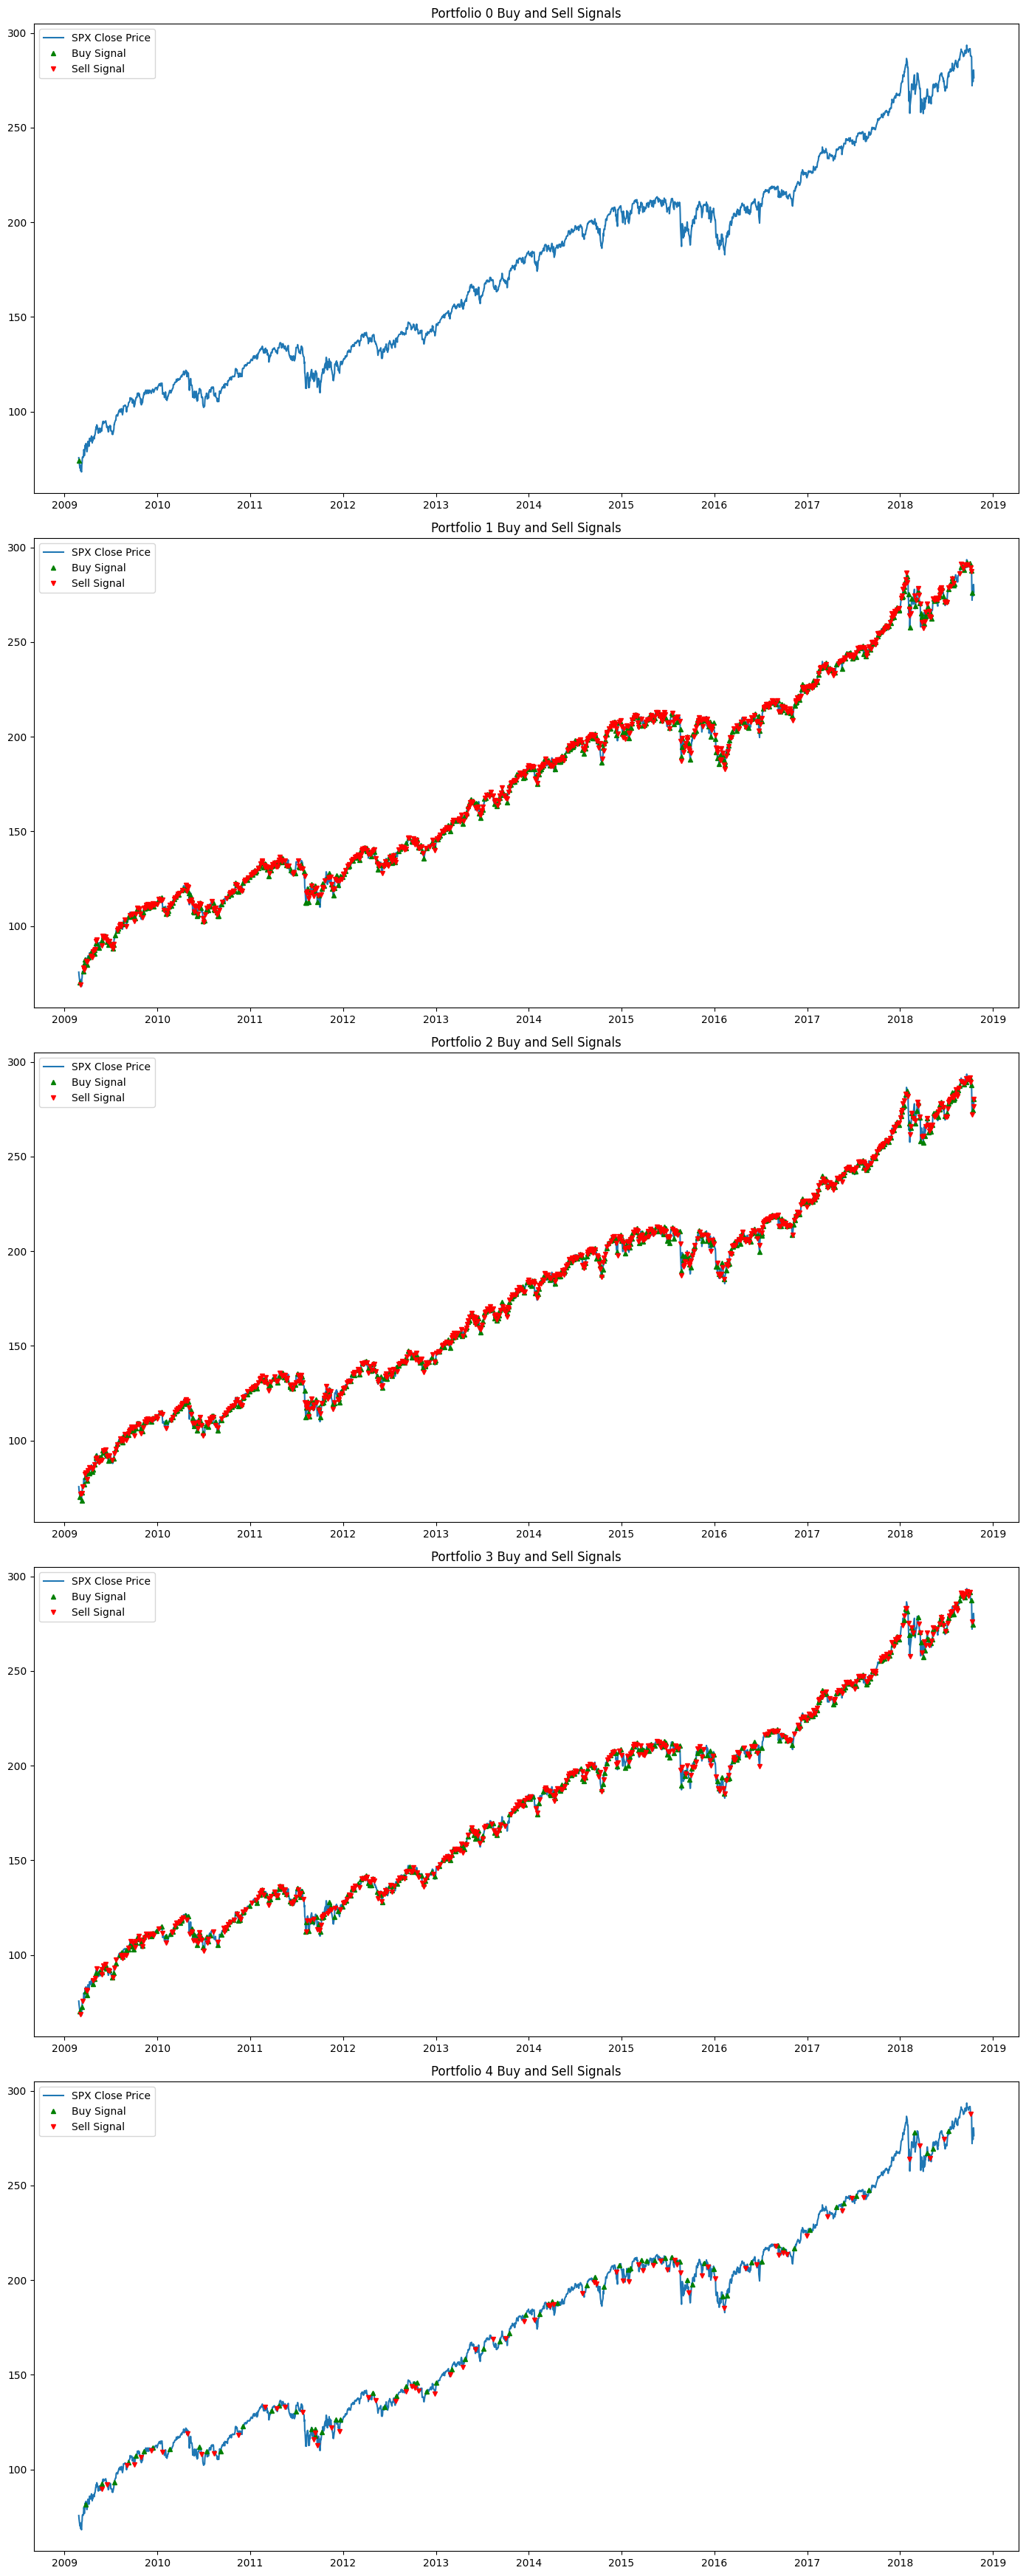

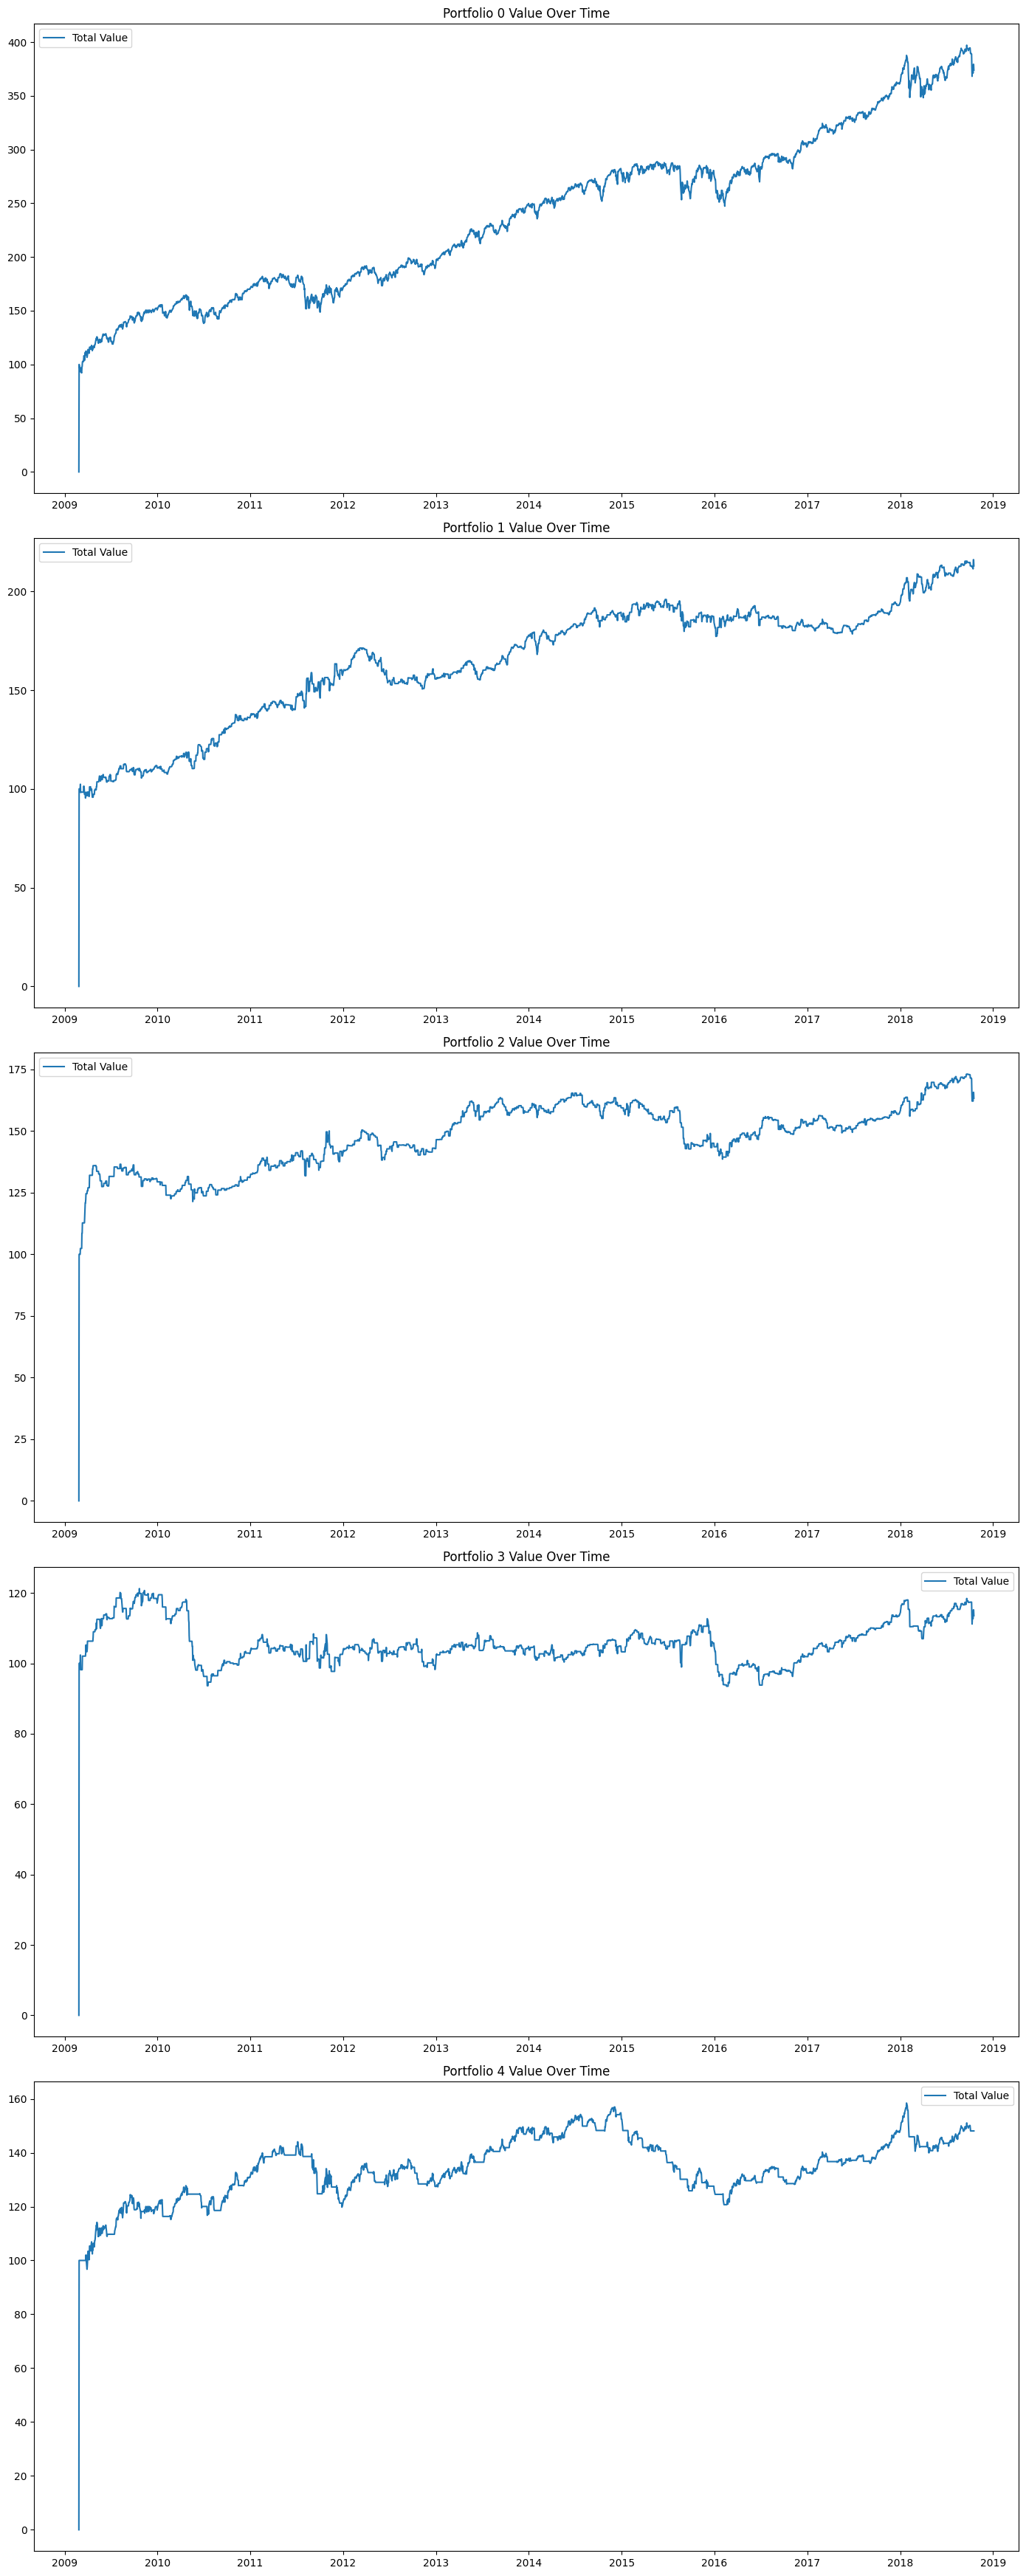

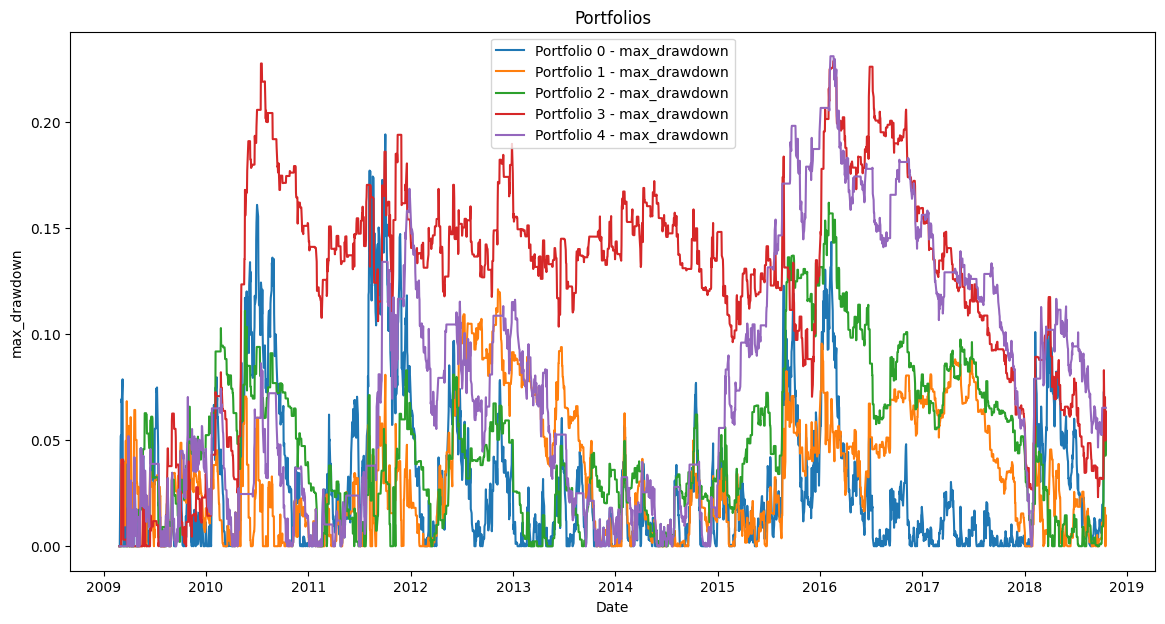

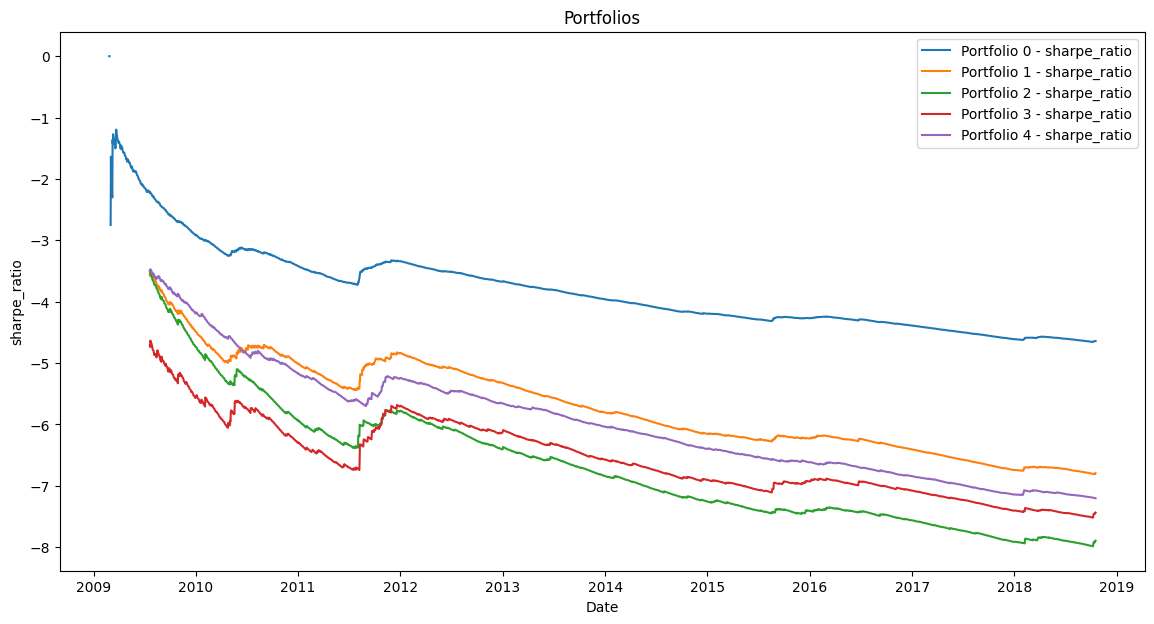

In [17]:
portfolio_signals([portfolio_0, portfolio_1, portfolio_2, portfolio_3, portfolio_4])
portfolio_val_over_time([portfolio_0, portfolio_1, portfolio_2, portfolio_3, portfolio_4])
plot_portfolio([portfolio_0, portfolio_1, portfolio_2, portfolio_3, portfolio_4], 'max_drawdown')
plot_portfolio([portfolio_0, portfolio_1.iloc[100:], portfolio_2.iloc[100:], portfolio_3.iloc[100:], portfolio_4.iloc[100:]], 'sharpe_ratio')

# Implementation

In [18]:
news = pd.read_csv('news_articles.csv', parse_dates=['Date']).set_index('Date').iloc[2300:4730]
spy = pd.read_csv('spy.csv', parse_dates=['Date']).set_index('Date').iloc[2300:4730]


In [19]:
#Changes news to weekly and creates rolling mean signal
def create_news(delt, news):
    news_wk = news.resample('7D').sum().reset_index()
    news_wk['rolling'] = news_wk['article_count'].rolling(delt).mean().shift(1)
    
    news_wk['signal'] = (news_wk['article_count'] > news_wk['rolling']).shift(1).mul(2).sub(1).mul(-1)
    news_wk['signal'][:delt] = np.nan
    news_wk['orders'] = news_wk['signal'].fillna(0).diff()
    return news_wk


In [20]:
#Runs backtest using signal instead of orders
def backtestLS(signal, initial_capital = 100, risk_free_rate = 0.0467):
    portfolio = pd.DataFrame(index=spy.index)
    
    portfolio['cash'] = 0
    portfolio['holding'] = 0
    portfolio['signal'] = signal
    portfolio['signal'] = portfolio['signal'].fillna(method='ffill').fillna(0)
    
    
    portfolio['total'] = 0
    portfolio['max_drawdown'] = 0  # New column for maximum drawdown
    portfolio['sharpe_ratio'] = 0  # New column for Sharpe Ratio
    portfolio.at[portfolio.index[0], 'cash'] = initial_capital
    portfolio['SPY'] = spy['Close']
    
    max_value = initial_capital
    returns = []
    
    
    for i in range(1, len(portfolio)):
        if portfolio.at[portfolio.index[i], 'signal'] == 1:
            portfolio.at[portfolio.index[i], 'cash'] = portfolio.at[portfolio.index[i-1], 'cash'] + portfolio.at[portfolio.index[i-1], 'holding'] * spy['Close'][i]
            portfolio.at[portfolio.index[i], 'holding'] = portfolio.at[portfolio.index[i], 'cash'] / spy['Close'][i]
            portfolio.at[portfolio.index[i], 'cash'] = 0
        elif portfolio.at[portfolio.index[i], 'signal'] == -1:
            portfolio.at[portfolio.index[i], 'cash'] = portfolio.at[portfolio.index[i-1], 'cash'] + portfolio.at[portfolio.index[i-1], 'holding'] * spy['Close'][i]
            portfolio.at[portfolio.index[i], 'holding'] = -portfolio.at[portfolio.index[i], 'cash'] / spy['Close'][i]
            portfolio.at[portfolio.index[i], 'cash'] = 2 * portfolio.at[portfolio.index[i], 'cash']
        else:
            portfolio.at[portfolio.index[i], 'cash'] = portfolio.at[portfolio.index[i-1], 'cash'] + portfolio.at[portfolio.index[i-1], 'holding'] * spy['Close'][i]
        if i == len(portfolio) - 1:
            portfolio.at[portfolio.index[i], 'cash'] = portfolio.at[portfolio.index[i-1], 'cash'] + portfolio.at[portfolio.index[i-1], 'holding'] * spy['Close'][i]
            portfolio.at[portfolio.index[i], 'holding'] = 0
     
        # Update total value and calculate drawdown
        portfolio.at[portfolio.index[i], 'total'] = portfolio.at[portfolio.index[i], 'cash'] + portfolio.at[portfolio.index[i], 'holding'] * spy['Close'][i]
        
        max_value = max(max_value, portfolio.at[portfolio.index[i], 'total'])
        portfolio.at[portfolio.index[i], 'max_drawdown'] = (max_value - portfolio.at[portfolio.index[i], 'total']) / max_value
    
        # Calculate daily returns
        if i > 1:
            daily_return = (portfolio.at[portfolio.index[i], 'total'] / portfolio.at[portfolio.index[i-1], 'total']) - 1
            returns.append(daily_return)
            #  Calculate Sharpe Ratio
            if pd.Series(returns).std() != 0:
                excess_returns = pd.Series(returns) - risk_free_rate
                sharpe_ratio = (excess_returns.mean() / excess_returns.std())
            else:
                sharpe_ratio = 0.0
            portfolio.at[portfolio.index[i], 'sharpe_ratio'] = sharpe_ratio
    
    return portfolio

In [21]:
from scipy.stats import skew, kurtosis
#Given a stream of returns, calculates stats, drawdown assumes a starting capital of 100
def calculateStats(returns):
    trading_days = 252
    
    mean = (1 + np.average(returns)) ** trading_days - 1
    vol = np.std(returns) * np.sqrt(trading_days)
    ir = mean / vol
    sk = skew(returns)
    kurt = kurtosis(returns)
    max_loss = np.min(returns)
    max_gain = np.max(returns)
    hit_rate = (returns > 0).sum() / returns.size
    print(returns, (returns > 0).sum(), returns.size)
    
    index = [100]
    for j in range(len(returns)):
        index.append(index[-1] * (1+returns[j]))
    drawdown = np.max(np.maximum.accumulate(index) - index)
    return [mean, vol, ir, sk, kurt, hit_rate, max_loss, max_gain, drawdown]

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\chaud\AppData\Local\Temp\ipykernel_1980\39720219.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_wk['signal'][:delt] = np.nan
 12%|█▎        | 1/8 [00:04<00:28,  4.12s/it]

                  cash   holding  signal       total  max_drawdown  \
Date                                                                 
2009-02-26  100.000000  0.000000     0.0    0.000000      0.000000   
2009-02-27  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-02  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-03  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-04  100.000000  0.000000     0.0  100.000000      0.000000   
...                ...       ...     ...         ...           ...   
2018-10-12  382.321075 -0.692736    -1.0  191.160538      0.013888   
2018-10-15  384.468583 -0.700562    -1.0  192.234291      0.008349   
2018-10-16  376.061835 -0.670581    -1.0  188.030918      0.030033   
2018-10-17  375.994753 -0.670342    -1.0  187.997376      0.030206   
2018-10-18  190.712273  0.000000    -1.0  190.712273      0.016201   

            sharpe_ratio         SPY   returns  
Date                                    

C:\Users\chaud\AppData\Local\Temp\ipykernel_1980\39720219.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_wk['signal'][:delt] = np.nan
 25%|██▌       | 2/8 [00:08<00:24,  4.03s/it]

                  cash   holding  signal       total  max_drawdown  \
Date                                                                 
2009-02-26  100.000000  0.000000     0.0    0.000000      0.000000   
2009-02-27  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-02  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-03  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-04  100.000000  0.000000     0.0  100.000000      0.000000   
...                ...       ...     ...         ...           ...   
2018-10-12  395.164958 -0.716008    -1.0  197.582479      0.013888   
2018-10-15  397.384610 -0.724097    -1.0  198.692305      0.008349   
2018-10-16  388.695442 -0.693109    -1.0  194.347721      0.030033   
2018-10-17  388.626106 -0.692862    -1.0  194.313053      0.030206   
2018-10-18  197.119155  0.000000    -1.0  197.119155      0.016201   

            sharpe_ratio         SPY   returns  
Date                                    

C:\Users\chaud\AppData\Local\Temp\ipykernel_1980\39720219.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_wk['signal'][:delt] = np.nan
 38%|███▊      | 3/8 [00:12<00:20,  4.11s/it]

                  cash   holding  signal       total  max_drawdown  \
Date                                                                 
2009-02-26  100.000000  0.000000     0.0    0.000000      0.000000   
2009-02-27  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-02  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-03  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-04  100.000000  0.000000     0.0  100.000000      0.000000   
...                ...       ...     ...         ...           ...   
2018-10-12  312.646390 -0.566491    -1.0  156.323195      0.073601   
2018-10-15  314.402532 -0.572891    -1.0  157.201266      0.068398   
2018-10-16  307.527841 -0.548373    -1.0  153.763921      0.088768   
2018-10-17  307.472984 -0.548178    -1.0  153.736492      0.088930   
2018-10-18  155.956622  0.000000    -1.0  155.956622      0.075774   

            sharpe_ratio         SPY   returns  
Date                                    

C:\Users\chaud\AppData\Local\Temp\ipykernel_1980\39720219.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_wk['signal'][:delt] = np.nan
 50%|█████     | 4/8 [00:16<00:16,  4.21s/it]

                  cash   holding  signal       total  max_drawdown  \
Date                                                                 
2009-02-26  100.000000  0.000000     0.0    0.000000      0.000000   
2009-02-27  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-02  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-03  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-04  100.000000  0.000000     0.0  100.000000      0.000000   
...                ...       ...     ...         ...           ...   
2018-10-12  382.126832 -0.692384    -1.0  191.063416      0.013888   
2018-10-15  384.273248 -0.700206    -1.0  192.136624      0.008349   
2018-10-16  375.870772 -0.670240    -1.0  187.935386      0.030033   
2018-10-17  375.803723 -0.670001    -1.0  187.901861      0.030206   
2018-10-18  190.615379  0.000000    -1.0  190.615379      0.016201   

            sharpe_ratio         SPY   returns  
Date                                    

C:\Users\chaud\AppData\Local\Temp\ipykernel_1980\39720219.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_wk['signal'][:delt] = np.nan
 62%|██████▎   | 5/8 [00:20<00:12,  4.17s/it]

                  cash   holding  signal       total  max_drawdown  \
Date                                                                 
2009-02-26  100.000000  0.000000     0.0    0.000000      0.000000   
2009-02-27  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-02  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-03  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-04  100.000000  0.000000     0.0  100.000000      0.000000   
...                ...       ...     ...         ...           ...   
2018-10-12  436.507122 -0.790917    -1.0  218.253561      0.013888   
2018-10-15  438.958994 -0.799852    -1.0  219.479497      0.008349   
2018-10-16  429.360765 -0.765622    -1.0  214.680382      0.030033   
2018-10-17  429.284174 -0.765349    -1.0  214.642087      0.030206   
2018-10-18  217.741764  0.000000    -1.0  217.741764      0.016201   

            sharpe_ratio         SPY   returns  
Date                                    

C:\Users\chaud\AppData\Local\Temp\ipykernel_1980\39720219.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_wk['signal'][:delt] = np.nan
 75%|███████▌  | 6/8 [00:25<00:08,  4.23s/it]

                  cash   holding  signal       total  max_drawdown  \
Date                                                                 
2009-02-26  100.000000  0.000000     0.0    0.000000      0.000000   
2009-02-27  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-02  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-03  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-04  100.000000  0.000000     0.0  100.000000      0.000000   
...                ...       ...     ...         ...           ...   
2018-10-12  379.644474 -0.687886    -1.0  189.822237      0.013888   
2018-10-15  381.776947 -0.695658    -1.0  190.888473      0.008349   
2018-10-16  373.429054 -0.665886    -1.0  186.714527      0.030033   
2018-10-17  373.362441 -0.665649    -1.0  186.681221      0.030206   
2018-10-18  189.377110  0.000000    -1.0  189.377110      0.016201   

            sharpe_ratio         SPY   returns  
Date                                    

C:\Users\chaud\AppData\Local\Temp\ipykernel_1980\39720219.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_wk['signal'][:delt] = np.nan
 88%|████████▊ | 7/8 [00:29<00:04,  4.29s/it]

                  cash   holding  signal       total  max_drawdown  \
Date                                                                 
2009-02-26  100.000000  0.000000     0.0    0.000000      0.000000   
2009-02-27  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-02  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-03  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-04  100.000000  0.000000     0.0  100.000000      0.000000   
...                ...       ...     ...         ...           ...   
2018-10-12  410.952993 -0.744615    -1.0  205.476497      0.013888   
2018-10-15  413.261327 -0.753027    -1.0  206.630663      0.008349   
2018-10-16  404.225000 -0.720801    -1.0  202.112500      0.030033   
2018-10-17  404.152894 -0.720544    -1.0  202.076447      0.030206   
2018-10-18  204.994661  0.000000    -1.0  204.994661      0.016201   

            sharpe_ratio         SPY   returns  
Date                                    

C:\Users\chaud\AppData\Local\Temp\ipykernel_1980\39720219.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_wk['signal'][:delt] = np.nan
100%|██████████| 8/8 [00:33<00:00,  4.22s/it]

                  cash   holding  signal       total  max_drawdown  \
Date                                                                 
2009-02-26  100.000000  0.000000     0.0    0.000000      0.000000   
2009-02-27  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-02  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-03  100.000000  0.000000     0.0  100.000000      0.000000   
2009-03-04  100.000000  0.000000     0.0  100.000000      0.000000   
...                ...       ...     ...         ...           ...   
2018-10-12  366.813282 -0.664637    -1.0  183.406641      0.013888   
2018-10-15  368.873681 -0.672146    -1.0  184.436841      0.008349   
2018-10-16  360.807930 -0.643381    -1.0  180.403965      0.030033   
2018-10-17  360.743568 -0.643151    -1.0  180.371784      0.030206   
2018-10-18  182.976559  0.000000    -1.0  182.976559      0.016201   

            sharpe_ratio         SPY   returns  
Date                                    

Text(0.5, 1.0, 'Sensitivity Analysis')

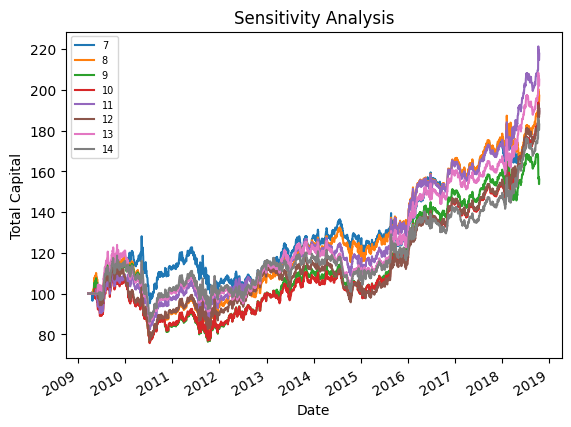

In [22]:
res = []
#Sensitivity analysis: runs for delta t = 7, ..., 14, optimal is 11, plots them too
for delt in tqdm(range(7, 15)):
    news_wk = create_news(delt, news)
    port = backtestLS(news_wk.set_index('Date')['signal'])
    port['total'].iloc[15:].plot(label=delt)
    port['returns'] = port['total'].pct_change()
    print(port)
    res.append(calculateStats(port['returns'].iloc[2:]))
plt.legend(fontsize=7)
plt.xlabel('Date')
plt.ylabel('Total Capital')
plt.title('Sensitivity Analysis')

In [23]:
news

,article_count
Date,
2009-02-26,1
2009-02-27,1
2009-03-02,0
2009-03-03,2
2009-03-04,2
...,...
2018-10-12,8
2018-10-15,9
2018-10-16,6


In [24]:
#Results
x = pd.DataFrame(res, columns=['Mean Return', 
                           'Volatility', 'Sharpe', 'Skewness', 'Kurtosis', 'Hit Rate',
                           'Max 1-day loss', 'Max 1-day gain', 'Max Drawdown'
                          ], 
            index = range(7, 15))
x

,Mean Return,Volatility,Sharpe,Skewness,Kurtosis,Hit Rate,Max 1-day loss,Max 1-day gain,Max Drawdown
7,0.081362,0.149801,0.543132,0.018478,3.895956,0.507002,-0.065123,0.046842,32.971262
8,0.084943,0.148989,0.570128,0.043897,3.871202,0.506590,-0.065123,0.046842,44.304254
9,0.058858,0.148762,0.395651,-0.040232,3.912730,0.502883,-0.065123,0.046842,41.970048
10,0.081038,0.148133,0.547062,-0.006151,3.944942,0.505766,-0.065123,0.046842,34.499073
11,0.095972,0.147537,0.650493,0.000810,4.008906,0.504942,-0.065123,0.046842,29.528340
12,0.080153,0.147173,0.544619,0.004696,4.041635,0.497941,-0.065123,0.046842,38.373786
13,0.089004,0.146741,0.606535,0.009488,4.090660,0.498764,-0.065123,0.046842,38.800896
14,0.076178,0.146360,0.520487,-0.006874,4.142160,0.495881,-0.065123,0.046842,32.442692


C:\Users\chaud\AppData\Local\Temp\ipykernel_1980\39720219.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_wk['signal'][:delt] = np.nan


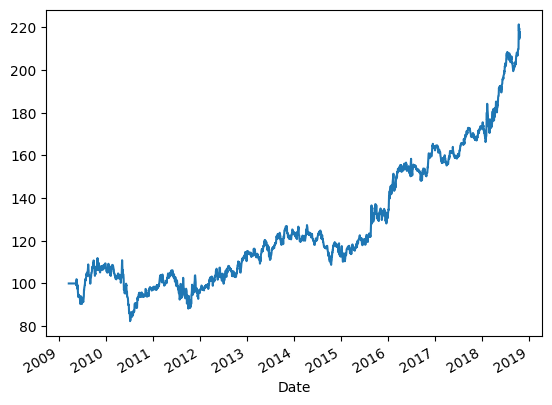

In [25]:
news_wk = create_news(11, news)
port = backtestLS(news_wk.set_index('Date')['signal'])
port['total'].iloc[15:].plot(label=delt)
port['returns'] = port['total'].pct_change()

<AxesSubplot: xlabel='Date'>

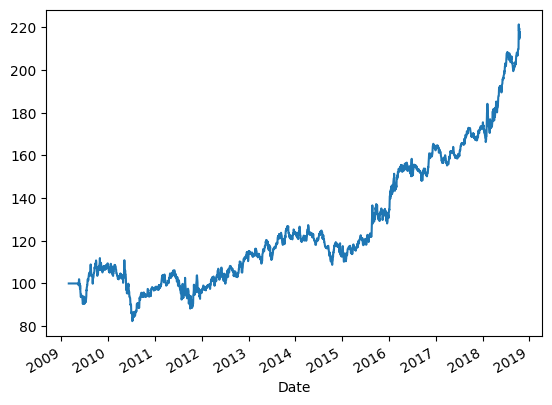

In [26]:
port['total'].iloc[1:].plot()

In [27]:
port.tail()

,cash,holding,signal,total,max_drawdown,sharpe_ratio,SPY,returns
Date,,,,,,,,
2018-10-12,436.507122,-0.790917,-1.0,218.253561,0.013888,-4.988926,275.950012,-0.013888
2018-10-15,438.958994,-0.799852,-1.0,219.479497,0.008349,-4.989393,274.399994,0.005617
2018-10-16,429.360765,-0.765622,-1.0,214.680382,0.030033,-4.985520,280.399994,-0.021866
2018-10-17,429.284174,-0.765349,-1.0,214.642087,0.030206,-4.986568,280.450012,-0.000178
2018-10-18,217.741764,0.000000,-1.0,217.741764,0.016201,-4.984614,276.399994,0.014441


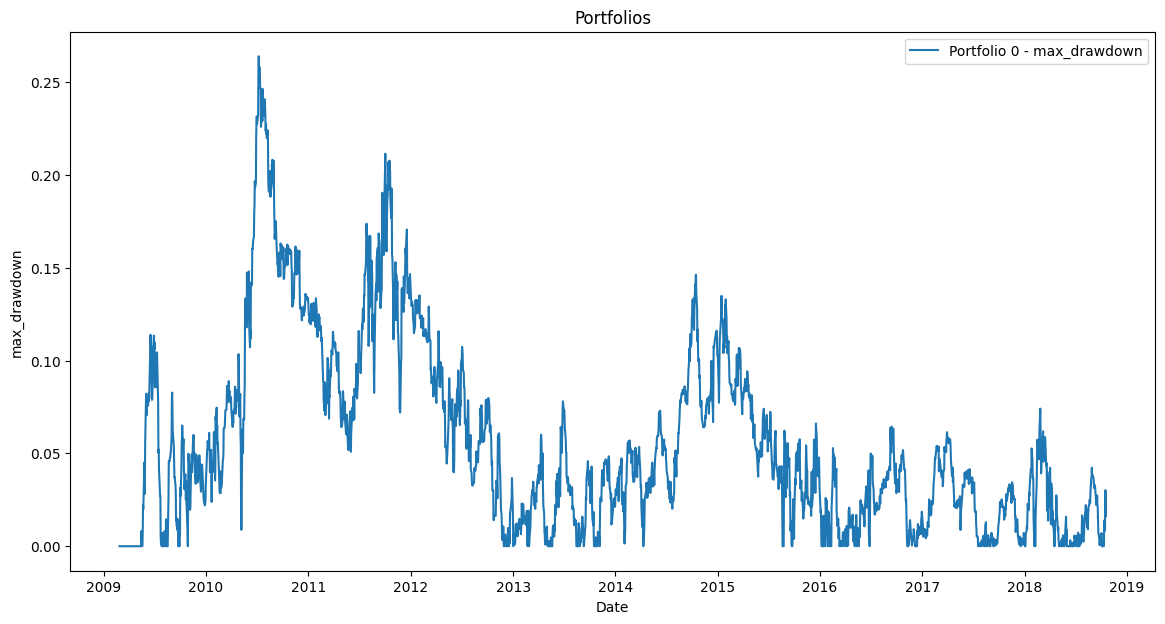

In [28]:
plot_portfolio([port])

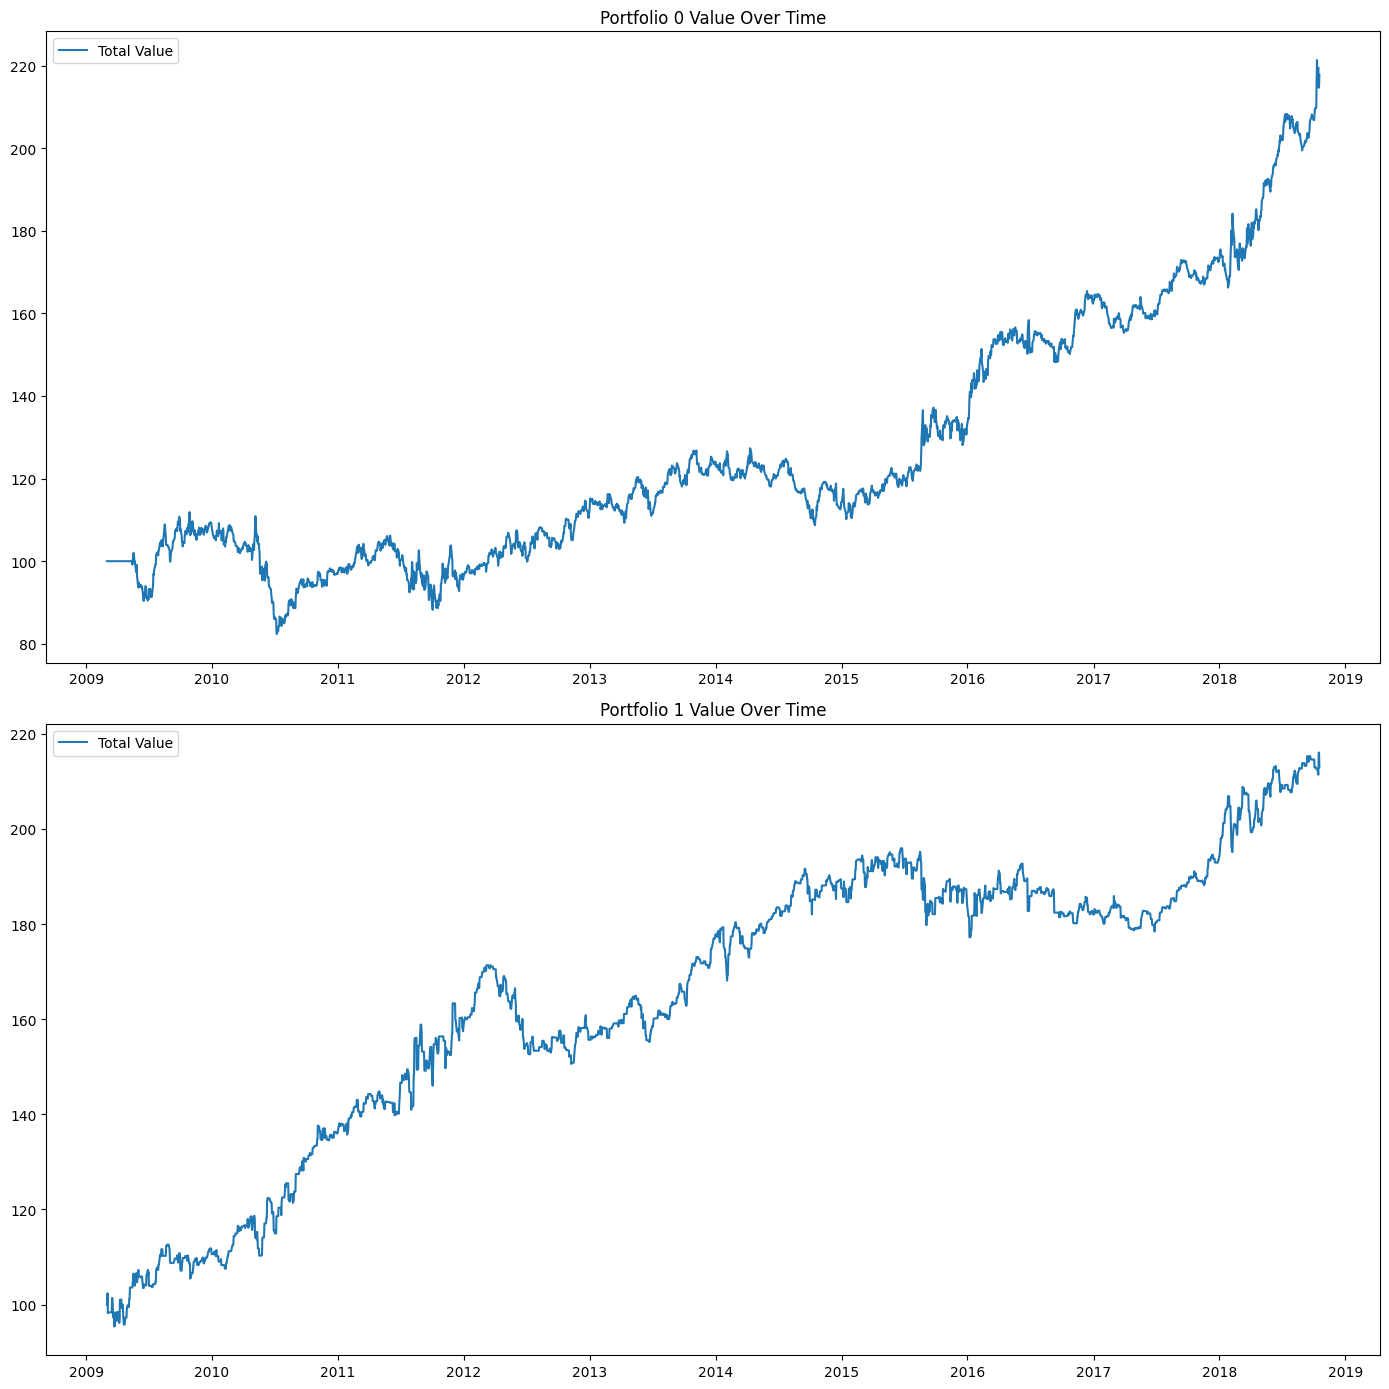

In [29]:
portfolio_val_over_time([port.iloc[2:], portfolio_1.iloc[2:]])